In [76]:
import os
import glob
import numpy as np

import torchvision
from torchvision.io import read_image
import torchvision.transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn

import torch
import matplotlib.pyplot as plt

torch.cuda.is_available()

True

/home/alexander/Project/gobot/board-vision/src
Raw Samples: 1083 971
Samples:  194200


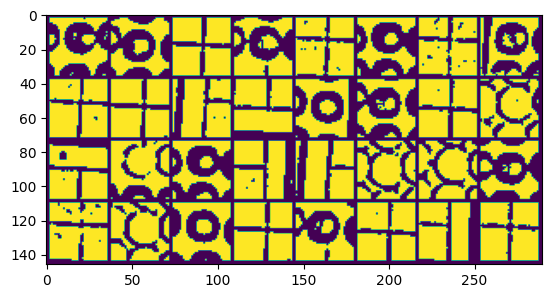

In [77]:

class CrossImageDataset():
    def __init__(self, folder: str, repeat: int = 1):
        self.image_empty = glob.glob(f'../{folder}/empty/**/raw*.png', recursive=True)
        self.full_empty = glob.glob(f'../{folder}/full/**/raw*.png', recursive=True)
        self.repeat = repeat
        self.num_samples = min(len(self.image_empty), len(self.full_empty))
        print("Raw Samples:", len(self.image_empty), len(self.full_empty))
        print("Samples: ", self.num_samples * 2 * self.repeat)
        
        self.cache = {}
        
        self.tranform_list = [    
            torchvision.transforms.RandomRotation(degrees=(0,180), expand=True),
            torchvision.transforms.CenterCrop(size=ACTUAL_SIZE),
            torchvision.transforms.CenterCrop(size=TARGET_SIZE),
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.RandomVerticalFlip()
        ]
        self.image_transform = torchvision.transforms.Compose(self.tranform_list)
        
    def __len__(self):
        return self.num_samples * 2 * self.repeat
    
    def __getitem__(self, idx):
        real_idx = idx % self.num_samples
        
        if self.cache.get(real_idx) is None:
        
            if idx % 2 == 0:
                image = read_image(self.image_empty[real_idx//2])
                label = torch.tensor([0, 1], dtype=torch.float32)
            else:
                image = read_image(self.full_empty[real_idx//2])
                label = torch.tensor([1, 0], dtype=torch.float32)
                
            self.cache[real_idx] = (image, label)
            
            if len(self.cache) > 10000:
                self.cache.pop(list(self.cache.keys())[0])
            
        else:
            image, label = self.cache[real_idx]
            
        image = image.float()/255.0
            
        #return torch.tensor(np.random.random(size=(3, 25, 25))).float(), label
        return image[0:1,:,:], label

    
ACTUAL_SIZE = (30, 30)
TARGET_SIZE = (25, 25)
    
print(os.getcwd())
dataset = CrossImageDataset('out', repeat=100)

train_dataset, test_dataset = random_split(dataset, [0.8, 0.2])
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

torch.manual_seed(0)

dataiter = iter(trainloader)
images, labels = next(dataiter)
plt.imshow(torchvision.utils.make_grid(images)[0,:,:])



In [78]:
def eval_model(m: nn.Module, dataloder: torch.utils.data.DataLoader, dataset: CrossImageDataset, GPU=0):
    correct = 0
    total = 0

    # again no gradients needed
    with torch.no_grad():
        for data in dataloder:
            inputs, labels = data
            inputs, labels = inputs.to(GPU), labels.to(GPU)
            inputs = dataset.image_transform(inputs)
            outputs = m(inputs)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, outputs):
                total += 1
                if torch.argmax(prediction) == torch.argmax(label):
                    correct += 1                

    # print accuracy for each class
    return 100 * float(correct) /   total


[1,  4000] loss: 0.389344
[2,  4000] loss: 0.321588
[3,  4000] loss: 0.317410
[4,  4000] loss: 0.317802
[5,  4000] loss: 0.321051
Accuracy: 99.34088568486096
Finished Training


/tmp/ipykernel_69774/2984935090.py:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper left")


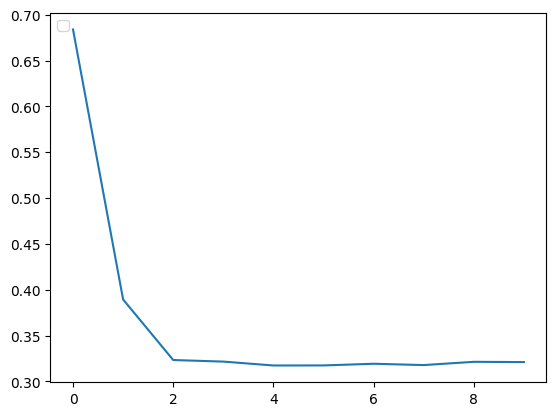

In [93]:
import importlib
import model
importlib.reload(model)

GPU = 0
net = model.Net()
net.to(GPU)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

acc_history = []
loss_history = []

for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(GPU), labels.to(GPU) 
        inputs = dataset.image_transform(inputs)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        if i % 2000 == 1999:    # print every 2000 mini-batches
            #acc = eval_model(net, testloader, dataset)
            loss_history.append(running_loss / 2000)
            #acc_history.append(acc)
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.6f}', end='\r')
            running_loss = 0.0
            
    print()

loss_history = np.array(loss_history)

print("Accuracy:", eval_model(net, testloader, dataset))
print('Finished Training')

plt.plot(loss_history)
plt.legend(loc="upper left")
plt.show()


In [94]:
# save the model
torch.save(net.state_dict(), '../models/model1.pth')